# Linear Gaussian

In [1]:
#%%
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from loss_cal.tasks.linear_gaussian import LinGauss
from loss_cal.costs import RevGaussCost
from loss_cal.actions import Action
from loss_cal.utils.utils import load_data, atleast_2d_col
from loss_cal.bam import train, build_nn

plot_config_file = "loss_cal/utils/.matplotlibrc"
seed = 0

In [3]:
import sbi
sbi.__version__

'0.21.0'

## Set Up

In [4]:
lingauss = LinGauss(action_type="continuous")
lingauss.task_name

'linear_gaussian'

Prior and Simulator

In [5]:
prior = lingauss.get_prior()
simulator = lingauss.get_simulator()

In [6]:
print(lingauss.dim_data,              # dimensionality data, here: 10
      lingauss.dim_parameters,        # dimensionality parameters, here: 2
      lingauss.num_observations)      # number of different observations x_o available, here: 10

10 10 10


10 observations provided by the sbibm task

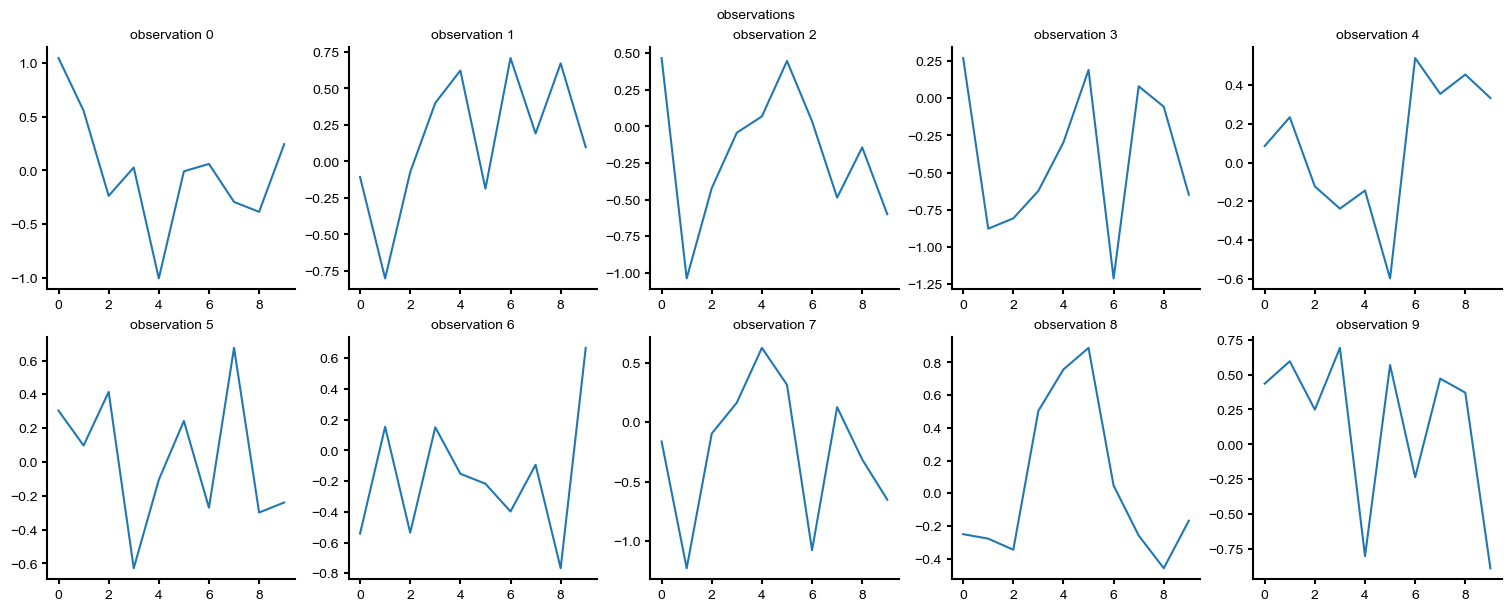

In [7]:
with mpl.rc_context(fname=plot_config_file):
    lingauss.plot_observations(2,5)
    plt.show()  

Prior

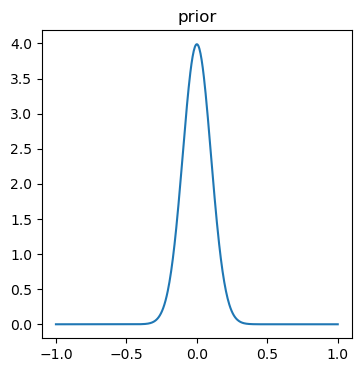

In [8]:
# priors defined as Log Normal with 
mu = 0
sigma = 1/10

ths  = torch.linspace(-1, 1, 500)
normal1 = torch.distributions.Normal(mu, sigma)

fig, axes = plt.subplots(1,1,figsize=(4,4))
axes.plot(ths, torch.exp(normal1.log_prob(ths)))
axes.set_title(r'prior')
plt.show()

In [9]:
normal1.icdf(torch.tensor([0.9995])), normal1.icdf(torch.tensor([0.0005]))

(tensor([0.3291]), tensor([-0.3291]))

Posterior

Only 10 reference samples given

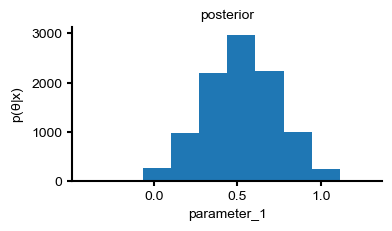

In [10]:
param = 0
n_obs = 1
posterior_evals = lingauss.get_reference_samples(n_obs)[:, param]
with mpl.rc_context(fname=plot_config_file):
    fig, ax = plt.subplots(1, 1, figsize=(4, 2))
    ax.hist(posterior_evals)
    ax.set_xlabel(rf"{lingauss.parameter_names[param]}")
    ax.set_ylabel(r"$p(\theta|x)$")
    ax.set_title("posterior")
    plt.show()

## Continuous Actions

### Decision Task

RevGaussCost(
parameter_range=[-0.32910001277923584, 0.32910001277923584],
action_range=[0.0, 100.0],
factor=0.5,
exponential=2,
offset=0.32910001277923584
)


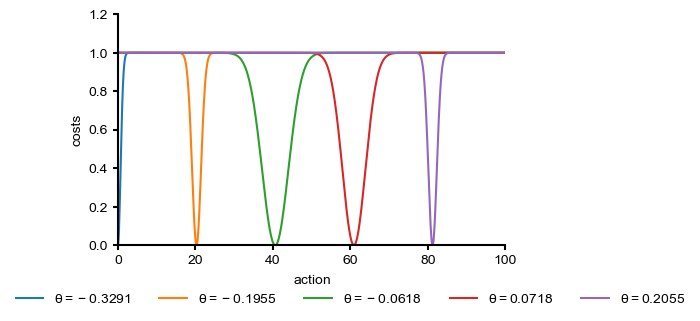

In [11]:
factor = 0.5
exponential = 2
param_plot = 0
cost_fn = RevGaussCost(
    parameter_range=[
        lingauss.param_low[param_plot].item(),
        lingauss.param_high[param_plot].item(),
    ],
    action_range=[lingauss.action_low, lingauss.action_high],
    factor=factor,
    exponential=exponential,
    offset=lingauss.param_high[param_plot],
    aligned=True
)

print(
    f"RevGaussCost(\nparameter_range={[lingauss.param_low[param_plot].item(), lingauss.param_high[param_plot].item()]},\naction_range={[lingauss.action_low, lingauss.action_high]},\nfactor={factor},\nexponential={exponential},\noffset={lingauss.param_high[param_plot]}\n)"
)

with mpl.rc_context(fname=plot_config_file):
    resolution = 1000
    actions = torch.arange(
        lingauss.action_low,
        lingauss.action_high,
        (lingauss.action_high - lingauss.action_low) / resolution,
    )

    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    for theta in torch.arange(
        lingauss.param_low[param_plot].item(),
        lingauss.param_high[param_plot].item() + 0.01,
        (lingauss.param_high[param_plot].item() + 0.01 -lingauss.param_low[param_plot].item())/ 5.,
    ):
        ax.plot(actions, cost_fn(theta, actions), label=rf"$\theta={theta:.4f}$")

    ax.set_xlabel(r"$action$")
    ax.set_ylabel("costs")
    ax.set_xlim(lingauss.action_low, lingauss.action_high)
    ax.set_ylim(0, 1.2)
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.6, -0.15),
        fancybox=True,
        shadow=True,
        ncol=6,
    )
    # plt.savefig("./results/continuous/toy_example/fig_cost_fct.pdf")
    plt.show()

In [12]:
x_reference = torch.vstack([lingauss.get_observation(i) for i in range(1,11)])
post_reference = torch.stack([lingauss.get_reference_samples(i) for i in range(1,11)])[:,:,param]
param_reference = torch.vstack([lingauss.get_true_parameters(i) for i in range(1,11)])[:,param]

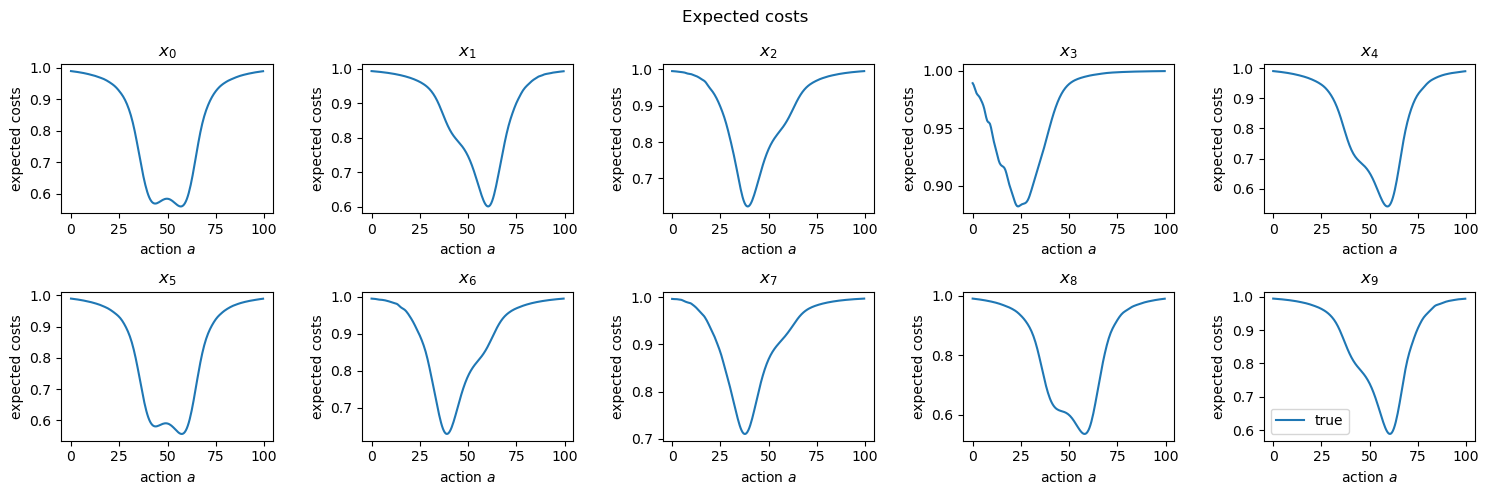

In [13]:
a_grid = torch.arange(lingauss.action_low, lingauss.action_high, 0.5)
expected_costs_post = []

plt.figure(figsize=(15, 5))
for i, x in enumerate(x_reference):
    plt.subplot(2, 5, i + 1 % 5)

    expected_posterior_costs = (
        cost_fn(lingauss.param_aggregation(lingauss.get_reference_samples(n=i + 1)), a_grid).mean(dim=0).unsqueeze(1)
    )
    expected_costs_post.append(expected_posterior_costs)

    plt.plot(a_grid, expected_posterior_costs, label="true")
    plt.xlabel(r"action $a$")
    plt.ylabel("expected costs")
    plt.title(rf"$x_{i}$")
plt.suptitle("Expected costs")
plt.tight_layout()
plt.legend()
# plt.savefig("./results/linear_gaussian/continuous//fig_expected_costs.pdf")
plt.show()

### Actions

### Load data

In [14]:
n_train = 50_000
n_test = 1_000

(
    theta,
    x,
    theta_test,
    x_test,
) = load_data("linear_gaussian")


# TRAIN-VAL SPLIT (90:10)
validation_fraction = 0.1
# Get total number of training examples.
num_examples = n_train
# Select random train and validation splits from (theta, x) pairs.
num_training_examples = int((1 - validation_fraction) * num_examples)
num_validation_examples = num_examples - num_training_examples
permuted_indices = torch.randperm(num_examples)
train_indices, val_indices = (
    permuted_indices[:num_training_examples],
    permuted_indices[num_training_examples:],
)

theta_train = lingauss.param_aggregation(theta[train_indices])
x_train = x[train_indices]
theta_val = lingauss.param_aggregation(theta[val_indices])
x_val = x[val_indices]

x_test = x_test[:n_test]
theta_test = lingauss.param_aggregation(theta_test[:n_test])

actions_evaluate = lingauss.actions.sample(theta_train.shape[0])

print(f"ntrain = {theta_train.shape[0]}, nval = {theta_val.shape[0]},  ntest = {theta_test.shape[0]}")

Load data from './data/linear_gaussian', device = cpu.
ntrain = 45000, nval = 5000,  ntest = 1000


### Train a neural network to predict expected costs

In [15]:
nn = build_nn(
    "fc",
    x_train=x_train,
    action_train=lingauss.actions.sample(theta_train.shape[0]),
    hidden_dims=[50,50,50],
    output_dim=1,
    activation=torch.nn.ReLU(),
    output_transform=torch.nn.Sigmoid(),
    seed = seed
)
print(nn, end="\n-----\n")

nn, train_loss, val_loss = train(
    model=nn,
    x_train=x_train,
    theta_train=theta_train,
    cost_fn= cost_fn, 
    x_val=x_val,
    theta_val=theta_val,
    actions=lingauss.actions, 
    learning_rate=1e-3,
    model_dir="./results/linear_gaussian/continuous/notebook",
    #max_num_epochs=800,
    stop_after_epochs=30,
    seed = seed, 
    sample_actions_in_loop=True
)

FeedforwardNN(
  (standardize_layer): Standardize()
  (input_layer): Linear(in_features=11, out_features=50, bias=True)
  (hidden_layers): ModuleList(
    (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
  )
  (final_layer): Linear(in_features=50, out_features=1, bias=True)
  (activation): ReLU()
  (output_transform): Sigmoid()
)
-----
Subdirectory 'checkpoints' already exists. Delete first if wanted.
138	 val_loss = 0.05775821	 train_loss = 0.00563909	 last_improvement = 30
---------------------------------------------------------------------------------
|	Converged after 138 epochs, best achieved validation loss: 0.0576.	|
---------------------------------------------------------------------------------



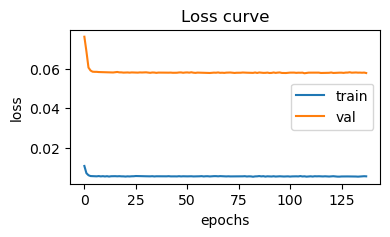

tensor(0.0576)


In [16]:
fig, ax = plt.subplots(1,1, figsize = (4,2))
ax.plot(train_loss[0:], label="train")
ax.plot(val_loss[0:], label = "val")
ax.set_title("Loss curve"); ax.set_xlabel("epochs"); ax.set_ylabel("loss")
ax.legend()
fig.savefig("./results/linear_gaussian/continuous/loss_curve.png")
plt.show()
print(val_loss.min())

### Evaluate model

In [17]:
x_reference = torch.vstack([lingauss.get_observation(i) for i in range(1,11)])
post_reference = torch.stack([lingauss.get_reference_samples(i) for i in range(1,11)])[:,:,param]
param_reference = torch.vstack([lingauss.get_true_parameters(i) for i in range(1,11)])[:,param]

Check predictions on the reference observations

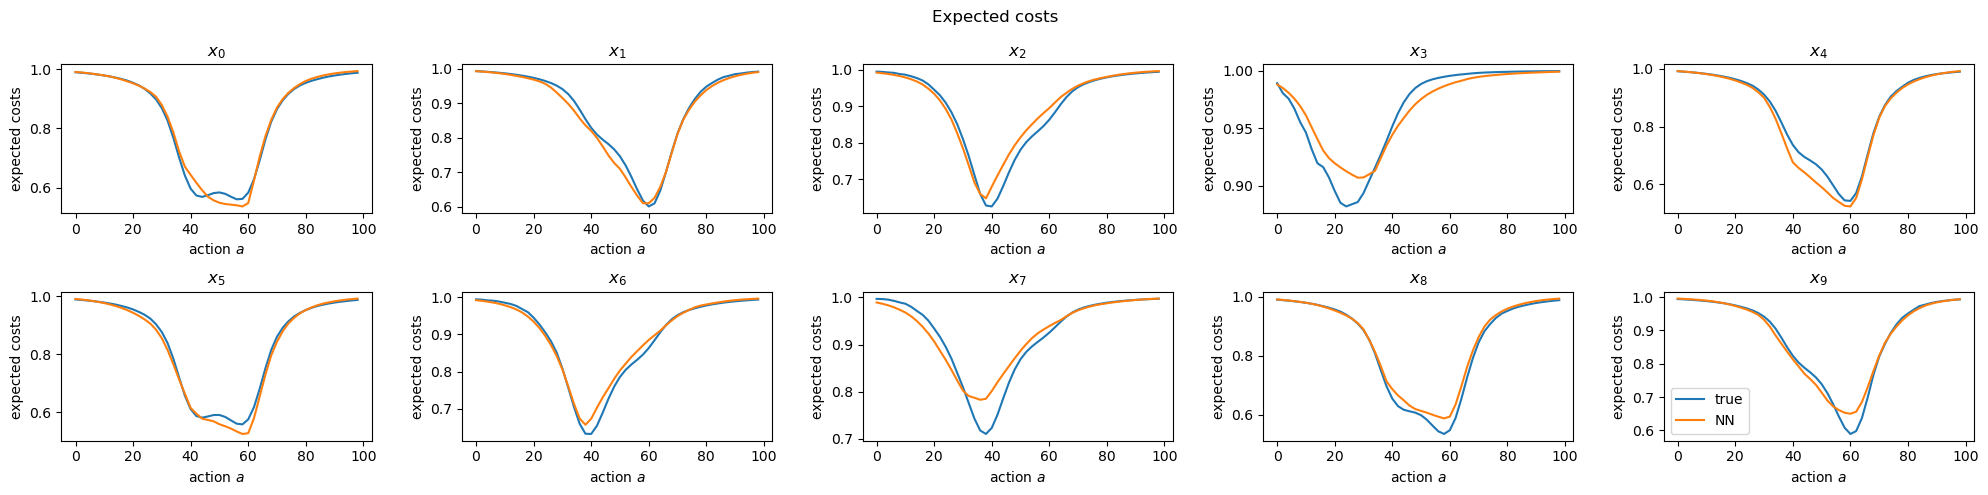

In [18]:
a_grid = torch.arange(lingauss.action_low, lingauss.action_high, 2.0)
expected_costs_post = []
expected_costs_nn = []

plt.figure(figsize=(20, 5))
for i, x in enumerate(x_reference):
    plt.subplot(2, 5, i + 1 % 5)


    expected_posterior_costs = cost_fn(lingauss.param_aggregation(lingauss.get_reference_samples(n=i+1)), a_grid).mean(dim=0).unsqueeze(1)

    # expected_posterior_costs = torch.tensor(
    #     [lingauss.expected_posterior_costs(n=i + 1, a=lingauss.rescale_fn(a), param=None, cost_fn=cost_fn, verbose=False) for a in a_grid]
    # )
    predicted_costs = torch.tensor([nn(x.unsqueeze(0), atleast_2d_col(a)).detach() for a in a_grid])
    expected_costs_post.append(expected_posterior_costs)
    expected_costs_nn.append(predicted_costs)

    plt.plot(a_grid, expected_posterior_costs, label="true")
    plt.plot(a_grid, predicted_costs, label="NN")
    plt.xlabel(r"action $a$")
    plt.ylabel("expected costs")
    plt.title(rf"$x_{i}$")
plt.suptitle("Expected costs")
plt.tight_layout()
plt.legend()
#plt.savefig("./results/linear_gaussian/continuous//fig_expected_costs.pdf")
plt.show()

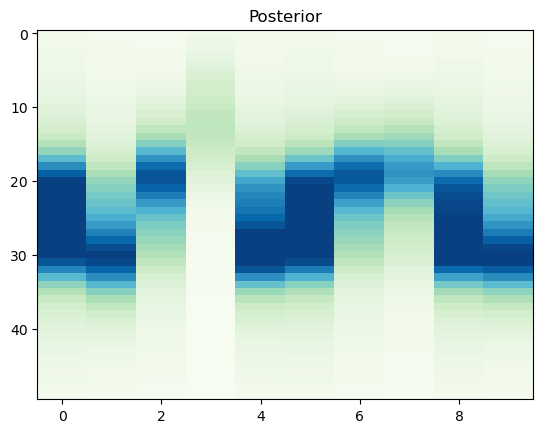

In [19]:
plt.title("Posterior")
plt.imshow(torch.hstack(expected_costs_post), aspect="auto", cmap="GnBu_r", vmin=0.6, vmax=1)
plt.show()

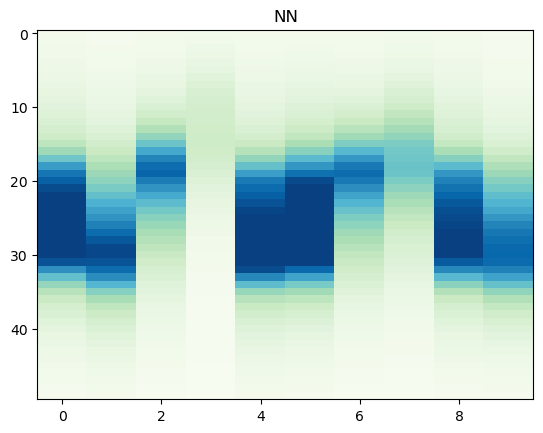

In [20]:
plt.title("NN")
plt.imshow(torch.stack(expected_costs_nn).T, aspect="auto", cmap="GnBu_r", vmin=0.6, vmax=1)
plt.show()